<a href="https://colab.research.google.com/github/krasomil/CodeMonkeyApplication/blob/master/Milosz_Team_4%F0%9F%8F%86%F0%9F%93%88Crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>📈Crypto</font>](https://www.kaggle.com/competitions/30oct23jh-crypto/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [1]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Mounted at /content/drive


In [2]:
# !pip -q install tensorflow==2.8 > log
# !apt -q install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 >> log
!pip -q install -U tfds-nightly tensorflow_addons tensorflow >> log

In [3]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
# !cp kaggle.json ~/.kaggle/kaggle.json > log       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 30oct23jh-crypto   # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

- competition is now set to: 30oct23jh-crypto
100% 5.94M/5.94M [00:00<00:00, 106MB/s]
Using competition: 30oct23jh-crypto
  teamId  teamName               submissionDate       score    
--------  ---------------------  -------------------  -------  
11192320  Brett Wolff            2023-11-07 18:38:02  0.15719  
11198447  Marko Zlatic           2023-11-07 01:51:22  0.15045  
11165029  Chris Durbin           2023-11-07 00:07:04  0.14974  
11205221  Baty Daniel            2023-11-07 16:22:47  0.14859  
11197707  Alec Wayne             2023-11-07 00:10:32  0.14275  
11197548  Alejandro Eguiarte     2023-11-07 02:02:13  0.13922  
10944814  📈Baseline🐍             2023-09-20 18:50:41  0.13056  
11147941  Sterling Belleau       2023-11-06 18:48:14  0.13012  
11193615  Edward Chang           2023-11-07 07:04:55  0.12930  
11198680  milosz.krasowski       2023-11-06 21:36:17  0.12876  
11194503  Phanupong Pattanachai  2023-11-07 06:42:37  0.12590  


See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [4]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15360 MiB, 15101 MiB, 0 MiB


In [5]:
!pip -q install -U tensorflow_addons > log   # update tfa in case students need to use it

In [6]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, RNN, LSTM, TimeDistributed
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 4.31 s, sys: 514 ms, total: 4.83 s
Wall time: 5.92 s


Your training data are 7 descriptive features for past 500K observations. See helpful [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition).

In [7]:
tXY = pd.read_csv('tXY.csv', index_col='id'); tXY

,Count,Open,High,Low,Close,Volume,VWAP
id,,,,,,,
0,64,0.20,0.20,0.20,0.20,447,0.20
1,72,0.20,0.20,0.20,0.20,592,0.20
...,...,...,...,...,...,...,...
499998,1636,1.15,1.16,1.15,1.15,2615,1.15
499999,3228,1.13,1.14,1.12,1.13,3354,1.13


Your task is to forecast the closing price for all future time steps (index IDs below).

In [8]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id'); pY.T

id,500000,500001,500002,500003,500004,500005,500006,500007,500008,500009,...,524421,524422,524423,524424,524425,524426,524427,524428,524429,524430
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>$\alpha$. Split observations into blocks of temporal train and test sets</b><h3>

In [10]:
# Import All Packages Here
import gc
import random
import os

In [11]:
# Feature flags for performing testing and validation - turn on when testing changes
TRAIN_WITH_VALIDATION_SET=False # Use a validation set when training and print the validation metrics at each training epoch

In [12]:
# Ensure consistent run timings by preventing unexpected memory management
gc.collect()
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, False)

0

In [13]:
# Ensure repeatability when using the GPU
# Credit: https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed
seed = 0
# tf.config.threading.set_inter_op_parallelism_threads(1)
# tf.config.threading.set_intra_op_parallelism_threads(1)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(seed)

<font color=green>This is your baseline DNN model. Remember to [seed all your experiments](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) for reproducibility. [Status of GPU-Determinism in TF](https://github.com/NVIDIA/framework-determinism/blob/master/tensorflow_status.md).

In [14]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.initializers import GlorotUniform
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class MovingAverageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=7, columns=None):
        self.window_size = window_size  # The size of the window for moving average
        if columns is None:
            self.columns = []  # Initialize columns as an empty list if None is passed
        else:
            self.columns = columns  # The columns on which to apply moving average

    def fit(self, X, y=None):
        # No fitting process needed for a stateless transformer, so just return self
        return self

    def transform(self, X):
        # Make a copy of the DataFrame to not alter the original one
        X_transformed = X.copy()

        # Apply moving average only to the specified columns
        for col in self.columns:
            # Apply the rolling window and calculate the mean
            X_transformed[f'{col}_sma_{self.window_size}'] = X_transformed[col].rolling(window=self.window_size).mean()

            # Fill any NaN values resulting from the rolling mean with the original values
            X_transformed[f'{col}_sma_{self.window_size}'].fillna(X_transformed[col], inplace=True)

        # Return the transformed DataFrame
        return X_transformed

# Moving Average calculation
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.append(np.array([np.nan]*n), ret[n - 1:] / n)[1:]

# Hull Moving Average calculation for inference
def calc_hull_ma_inference(series, N=50):
    # Check if the series is shorter than the required window size
    if len(series) < N:
        # If the series is too short, we cannot calculate the Hull Moving Average accurately
        return np.nan  # Returning NaN or some indicator that the HMA cannot be computed

    # Calculate the Simple Moving Averages (SMA1 and SMA2)
    SMA1 = moving_average(series, N)
    SMA2 = moving_average(series, int(N/2))

    # Make sure SMA2 is the same length as SMA1
    SMA1 = SMA1[-len(SMA2):]  # Slice SMA1 to match the length of SMA2

    # Calculate the Hull Moving Average (HMA)
    res = (2 * SMA2 - SMA1)
    # Use the sqrt of N for the final average part of the Hull calculation
    return np.mean(res[-int(np.sqrt(N)):])

class HullMovingAverageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_sizes=[50], columns=None):
        self.window_sizes = window_sizes  # List of window sizes for Hull Moving Average
        if columns is None:
            self.columns = []  # Initialize columns as an empty list if None is passed
        else:
            self.columns = columns  # The columns on which to apply Hull Moving Average

    def fit(self, X, y=None):
        # No fitting process needed for a stateless transformer, so just return self
        return self

    def transform(self, X):
        # Make a copy of the DataFrame to not alter the original one
        X_transformed = X.copy()

        # Apply Hull Moving Average only to the specified columns
        for col in self.columns:
            for window in self.window_sizes:
                hull_col_name = f'{col}_hull_{window}'
                # Calculate Hull Moving Average for the given window size
                X_transformed[hull_col_name] = X_transformed[col].rolling(window=window, min_periods=1).apply(
                    lambda x: calc_hull_ma_inference(x.values, N=window), raw=False)

                # Fill any NaN values that may have been created during the transformation
                X_transformed[hull_col_name].fillna(method='bfill', inplace=True)

        # Return the transformed DataFrame
        return X_transformed

# Example usage:
# Specify the columns that we want to apply the Hull Moving Average to
columns_to_apply_HMA = ['Close']

# Initialize transformer with desired window sizes
hma_transformer = HullMovingAverageTransformer(window_sizes=[50, 240], columns=columns_to_apply_HMA)




# Specify the columns that we want to apply the moving average to
columns_to_apply_MA = ['Count', 'Open', 'High', 'Low', 'Volume', 'VWAP']

# Create a pipeline with the preprocessor and any other steps you might need
pipeline = Pipeline(steps=[
    ('moving_average', MovingAverageTransformer(window_size=7, columns=columns_to_apply_MA)),
    # ('hm_tranformer', HullMovingAverageTransformer(window_sizes=[50, 240], columns=columns_to_apply_HMA)),
    ])

# Fit the pipeline to your data
pipeline.fit(tXY)

# Apply transformations to the entire dataset
tXY_transformed = pipeline.transform(tXY)

Pipeline(steps=[('moving_average',
                 MovingAverageTransformer(columns=['Count', 'Open', 'High',
                                                   'Low', 'Volume', 'VWAP']))])

In [15]:
tXY_transformed.head()

,Count,Open,High,Low,Close,Volume,VWAP,Count_sma_7,Open_sma_7,High_sma_7,Low_sma_7,Volume_sma_7,VWAP_sma_7
id,,,,,,,,,,,,,
0,64,0.2,0.2,0.2,0.2,447,0.2,64.0,0.2,0.2,0.2,447.0,0.2
1,72,0.2,0.2,0.2,0.2,592,0.2,72.0,0.2,0.2,0.2,592.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,77,0.2,0.2,0.2,0.2,515,0.2,77.0,0.2,0.2,0.2,515.0,0.2
4,77,0.2,0.2,0.2,0.2,682,0.2,77.0,0.2,0.2,0.2,682.0,0.2


taX.shape=(K,Nx,p)=(1000, 3550, 13); taY=(K,Ny)=(1000, 24431)


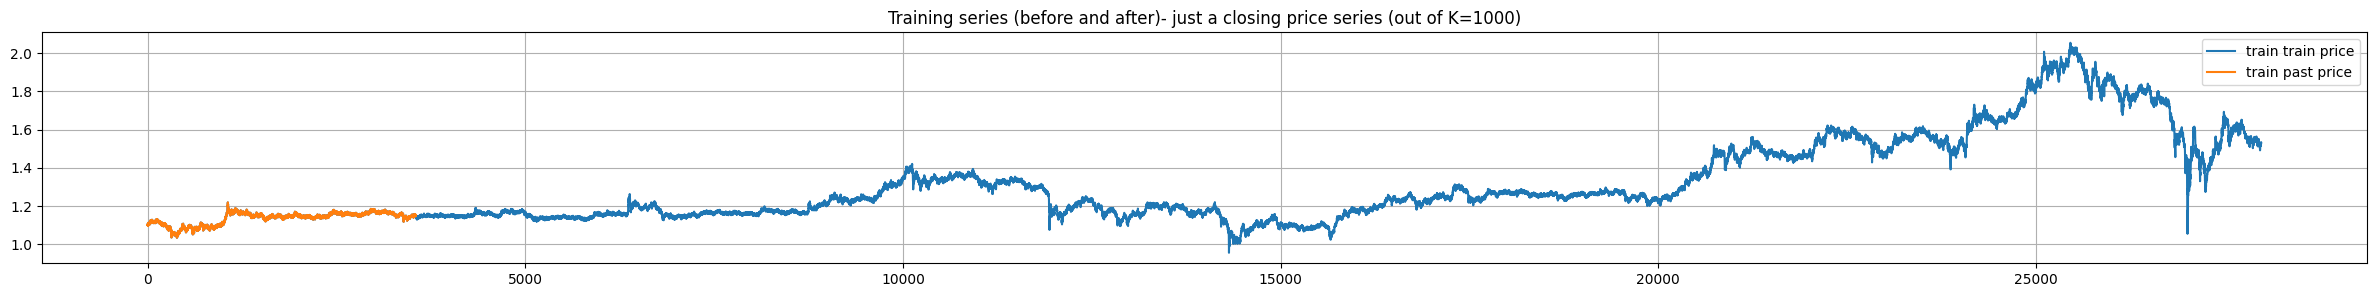

In [16]:
K, (N, p), Nx, Ny = 1000, tXY_transformed.shape, 3550, len(pY)  # samples, dataset dim, train set size, forecast set size
LtX, LtY = [], []
for i in range(N-Ny-K, N-Ny):                     # populate K samples with past X series and future Y series
  LtX.append(tXY_transformed.iloc[(i-Nx):i, :].values)        # X: historical 7Dim observations for Nx steps behind
  LtY.append(tXY_transformed.loc[i:(i+Ny-1),'Close'].values)  # Y: future closing prices for Ny steps ahead
taX, taY = np.array(LtX), np.array(LtY)           # training arrays past input X and future output Y

# Define the percentage for the validation set (e.g., 20%)
validation_percentage = 0.2

# Calculate the number of samples for the validation set
num_validation_samples = int(K * validation_percentage)

# Split the data into training and validation sets
# Training set
train_taX = taX[:-num_validation_samples]
train_taY = taY[:-num_validation_samples]

# Validation set
validation_taX = taX[-num_validation_samples:]
validation_taY = taY[-num_validation_samples:]

print(f'taX.shape=(K,Nx,p)={taX.shape}; taY=(K,Ny)={taY.shape}')  # convert to 3-tensors

df = pd.DataFrame(np.r_[taX[0,:,4], taY[0,:]], columns=['train train price'])
ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K})');
pd.DataFrame(taX[0,:,4], columns=['train past price']).plot(grid=True, ax=ax);

In [ ]:
taY.shape

(1000, 24431)

In [ ]:
print(taX.shape)
print(train_taX.shape)
print(validation_taX.shape)

(1000, 1000, 13)
(800, 1000, 13)
(200, 1000, 13)


In [ ]:
N = tXY_transformed.shape[0]  # Total number of rows in the DataFrame
Ny = len(pY)  # Number of future steps you want to predict
K = 70  # Number of samples you want to create

# The maximum size for Nx is then calculated as follows:
max_Nx = N - Ny - K
print(max_Nx)

475499


<font color=green><h3><b>$\beta$. Build and fit RNN</b><h3>

<font color=green>Build an LSTM model with two hidden layers. It splits $K$ samples into batches with 7D series $X_{N_x\times p}$ as input and 1D series $Y_{N_y\times 1}$ as output.


In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Define a custom metric for Pearson's R
def pearson_correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x - mx, y - my
    r_num = K.sum(tf.multiply(xm, ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    # To avoid NaN in division
    r = tf.where(tf.math.is_nan(r), tf.zeros_like(r), r)
    return r

In [26]:
%%time
Init = keras.initializers.glorot_uniform(seed=13)
l1_lr= 0.01
l2_lr= 0.01
bias_lr= 0.1
learning_rate= 0.005
beta_1= 0.9
beta_2= 0.7

m = Sequential(
  [LSTM(234, return_sequences=True, input_shape=[None, p], name='LSTM1', kernel_initializer=Init, recurrent_initializer=Init),
  Dropout(.1, name='d1'),
  LSTM(170, name='LSTM2', kernel_initializer=Init),
  Dropout(.1, name='d2'),
  Dense(Ny, name='out', kernel_initializer=Init) ], name='RNN_model') # we build Ny forecasts
m.summary()
m.compile(optimizer=keras.optimizers.Nadam(learning_rate= learning_rate, beta_1=beta_1, beta_2=beta_2), loss='mean_squared_error', metrics = [pearson_correlation_coefficient])
hist = m.fit(taX, taY, epochs=24, batch_size=32)

Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, None, 234)         232128    
                                                                 
 d1 (Dropout)                (None, None, 234)         0         
                                                                 
 LSTM2 (LSTM)                (None, 170)               275400    
                                                                 
 d2 (Dropout)                (None, 170)               0         
                                                                 
 out (Dense)                 (None, 24431)             4177701   
                                                                 
Total params: 4685229 (17.87 MB)
Trainable params: 4685229 (17.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/24
32/32 

In [ ]:
# _________________________________________________________________
# Epoch 1/10
# 2/2 [==============================] - 6s 2s/step - loss: 1.8195 - pearson_correlation_coefficient: 0.0106 - val_loss: 1.7277 - val_pearson_correlation_coefficient: 0.0294
# Epoch 2/10
# 2/2 [==============================] - 3s 2s/step - loss: 1.6976 - pearson_correlation_coefficient: 0.0323 - val_loss: 1.5424 - val_pearson_correlation_coefficient: 0.0515
# Epoch 3/10
# 2/2 [==============================] - 3s 2s/step - loss: 1.4947 - pearson_correlation_coefficient: 0.0501 - val_loss: 1.2776 - val_pearson_correlation_coefficient: 0.0709
# Epoch 4/10
# 2/2 [==============================] - 3s 2s/step - loss: 1.2150 - pearson_correlation_coefficient: 0.0667 - val_loss: 0.9702 - val_pearson_correlation_coefficient: 0.0873
# Epoch 5/10
# 2/2 [==============================] - 3s 2s/step - loss: 0.9140 - pearson_correlation_coefficient: 0.0787 - val_loss: 0.6670 - val_pearson_correlation_coefficient: 0.1055
# Epoch 6/10
# 2/2 [==============================] - 3s 2s/step - loss: 0.6266 - pearson_correlation_coefficient: 0.0895 - val_loss: 0.4061 - val_pearson_correlation_coefficient: 0.1315
# Epoch 7/10
# 2/2 [==============================] - 2s 1s/step - loss: 0.3628 - pearson_correlation_coefficient: 0.1113 - val_loss: 0.2069 - val_pearson_correlation_coefficient: 0.1818
# Epoch 8/10
# 2/2 [==============================] - 2s 1s/step - loss: 0.1827 - pearson_correlation_coefficient: 0.1413 - val_loss: 0.0821 - val_pearson_correlation_coefficient: 0.2857
# Epoch 9/10
# 2/2 [==============================] - 3s 2s/step - loss: 0.0754 - pearson_correlation_coefficient: 0.2274 - val_loss: 0.0367 - val_pearson_correlation_coefficient: 0.4796
# Epoch 10/10
# 2/2 [==============================] - 3s 2s/step - loss: 0.0427 - pearson_correlation_coefficient: 0.3784 - val_loss: 0.0508 - val_pearson_correlation_coefficient: 0.7297

<font color=green><h3><b>$\gamma$. Visualize forecasts</b><h3>

<font color=green>The plot below: the model memorized the prices from recent history (plus some local noise). Still you can use these predictions to visually (i.e. qualitatively) determine whether predictions are meaningful (i.e. have price-like shape) or just noise.

tX_recent.shape=(Nx,p)=(3550, 13)
1/1 [==============================] - 1s 712ms/step


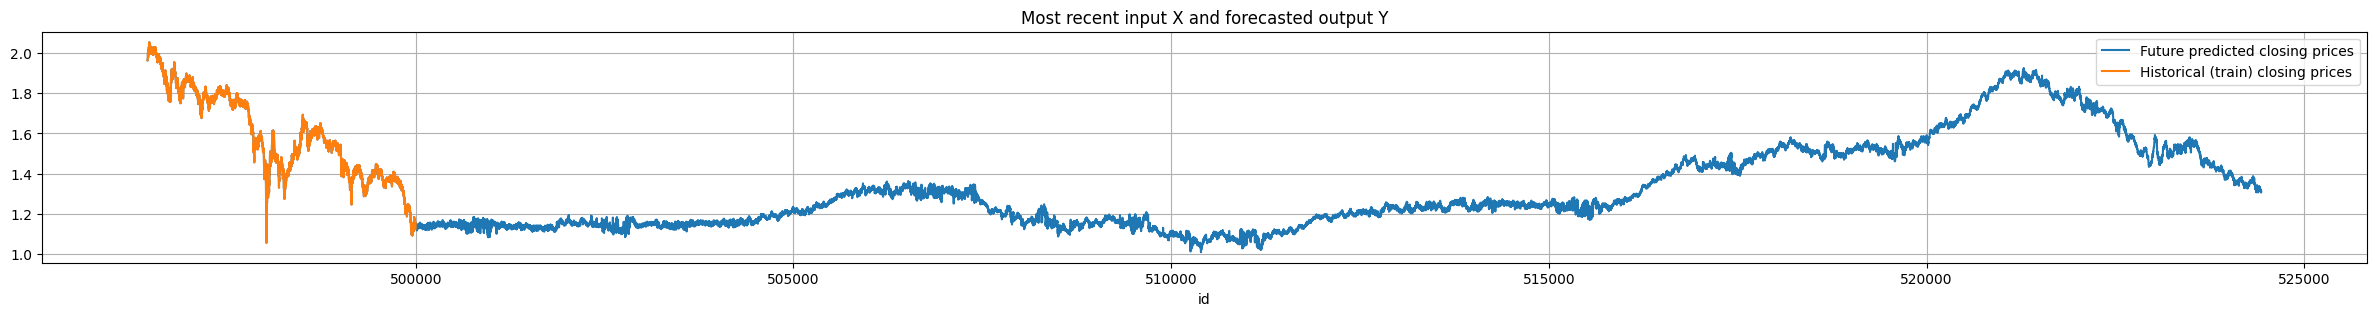

In [27]:
tX_recent = tXY_transformed.iloc[-Nx:,:]  # most recent history of the coin
print(f'tX_recent.shape=(Nx,p)={tX_recent.shape}')
pY['Close'] = m.predict(tX_recent.values[np.newaxis,...]).flatten()  # the model expects a 3-tensor (K=1,Nx,p)
ax = pd.concat([tX_recent.Close, pY.Close]).plot(figsize=(30,3), title='Most recent input X and forecasted output Y');
tX_recent.Close.plot(ax=ax, grid=True);
ax.legend(["Future predicted closing prices", "Historical (train) closing prices"]);

tX_recent.shape=(Nx,p)=(1000, 13)
1/1 [==============================] - 1s 644ms/step


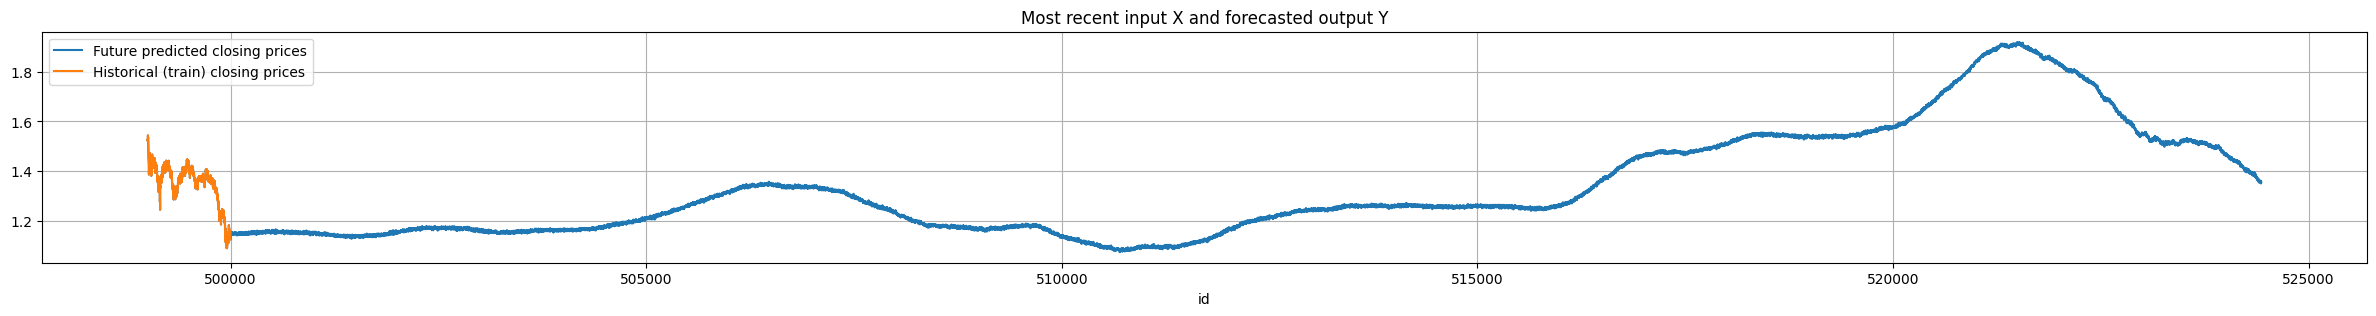

In [ ]:
tX_recent = tXY_transformed.iloc[-Nx:,:]  # most recent history of the coin
print(f'tX_recent.shape=(Nx,p)={tX_recent.shape}')
pY['Close'] = m.predict(tX_recent.values[np.newaxis,...]).flatten()  # the model expects a 3-tensor (K=1,Nx,p)
ax = pd.concat([tX_recent.Close, pY.Close]).plot(figsize=(30,3), title='Most recent input X and forecasted output Y');
tX_recent.Close.plot(ax=ax, grid=True);
ax.legend(["Future predicted closing prices", "Historical (train) closing prices"]);

<font color=green>

1. The model generates a baseline submission CSV file, see Colab folder (🗀 on the left).
1. You can download the generated CSV file and submit it to Kaggle.

<font color=green><h3><b>$\delta$. Make predictions</b><h3>

In [28]:
ToCSV(pY, '📈Milosz🐍')

<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

<font color=green><h3><b>$\zeta$. References</b></h3></font>

<font color=red><b>Your answer here.</b></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, HOML textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

1. ...
1. ...

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 931 sec > 300 sec limit!!!


# 💡**Starter Ideas**

1. Try different RNN architectures and hyperparameters
1. Try [correlation loss/metric](https://duckduckgo.com/?q=correlation+loss+in+tensorflow&ia=web) (or equivalent)
1. Try longer/shorter history. FYI: GPU may not fit all observations, but you could lower the precision or simplify DNN
1. Try forecasting returns (differences or log differences at different lags) instead of actual values. Returns might appear "more" stationary (You'll need to compute forecasted prices from forecasted returns later)
1. Try new features: differences, fractions, powers of existing features, lagged features or lagged differences,..
1. Try a different time scale. Eg. forecasting every $k$ steps and then imputing interim values
1. Try technique in HOML pp.509-510
1. Try (programmatically) assigning higher/lower weights to history or historical events (such as extreme events)
1. Check [Kaggle G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting/code) competition for more suitable ideas.
1. Try further smoothing/averaging and forecasting values at sparser intervals
1. Try forecasting just the future trend